<a href="https://colab.research.google.com/github/Funmiadebajo/GIS/blob/main/PS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Shared Housing as a Solution to Intergenerational Homelessness in Camden City, Camden NJ**



According to Monarch Housing, (2024) Camden City with a poverty rate of 36%, contributed nearly 68% to the homeless population in New Jersey in the January 2024 Point-in-Time Counts. According to recent estimates, Camden County's unsheltered homeless count has surged, with more than 84% of the county's unsheltered individuals residing in Camden City alone.

Of particular concern is the demographic composition of Camden's homeless population, as 316 individuals fall within the 18 to 44 age range—a vibrant group whose potential contributions to economic development are hindered by the destabilizing effects of homelessness(Monarch Housing, 2024). The constant stress of survival in unstable housing situations leads to chronic physical and mental health conditions, low educational attainment, and difficulties in securing long-term employment (Shinn et al., 2005).

The Corporation for Supportive Housing (2015) estimated that without intervention, 50% of those experiencing homelessness for the first time will have additional episodes. There is therefore an urgent need for innovative and proactive "prevention-as-cure" approaches to address this crisis to alter the trajectory of homelessness for future generations significantly.


**Research Objective**
To explore the potential of formal shared housing program for single adults at risk of homelessness in Camden, NJ.

In [30]:
%%capture
!pip install geopandas==1.0.1
!pip install mapclassify
import seaborn as sns

In [31]:
pip install contextily

In [32]:
import os, zipfile #basics
import pandas as pd #data management
import matplotlib.pyplot as plt #vis

import geopandas as gpd #gis/maps: a sister of pandas; does the job;
#tho not as fancy-interactive as folium or leafmap https://geopandas.org/

import mapclassify #need for thematic map classification

import re
from matplotlib.colors import ListedColormap


#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from google.colab import files #to download from colab onto hd

#from google.colab import data_table
#data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )
from google.colab.data_table import DataTable
DataTable.max_columns = 250

In [33]:
#!python --version
gpd.__version__

'1.0.1'

#HOMELESSNESS: A VISIBLE INDICATOR OF URBAN POVERTY

Homelessness is one of the most visible indicators of urban poverty across America. While poverty and homelessness are closely linked, they are distinct issues. The U.S. Department of Housing and Urban Development (HUD) defines homelessness as individuals and families who lack a fixed, regular, and adequate nighttime residence. This includes those living in shelters, transitional Housing, or places not meant for human habitation (U.S. Department of Housing and Urban Development, 2019).

Intergenerational homelessness occurs when families that experience homelessness pass these conditions onto younger generations, creating a self-perpetuating cycle.
A large body of academic research shows that increasing housing costs is the most basic macroeconomic cause of homelessness. When median rents increase by $100, homelessness rates rise by nine percent; and about 74% of highly low-income renters pay above 50% of their income on rent. (Horowitz et al., 2023, National Alliance to End Homelessness, 2024).


# Causes of Homelessness in Camden County

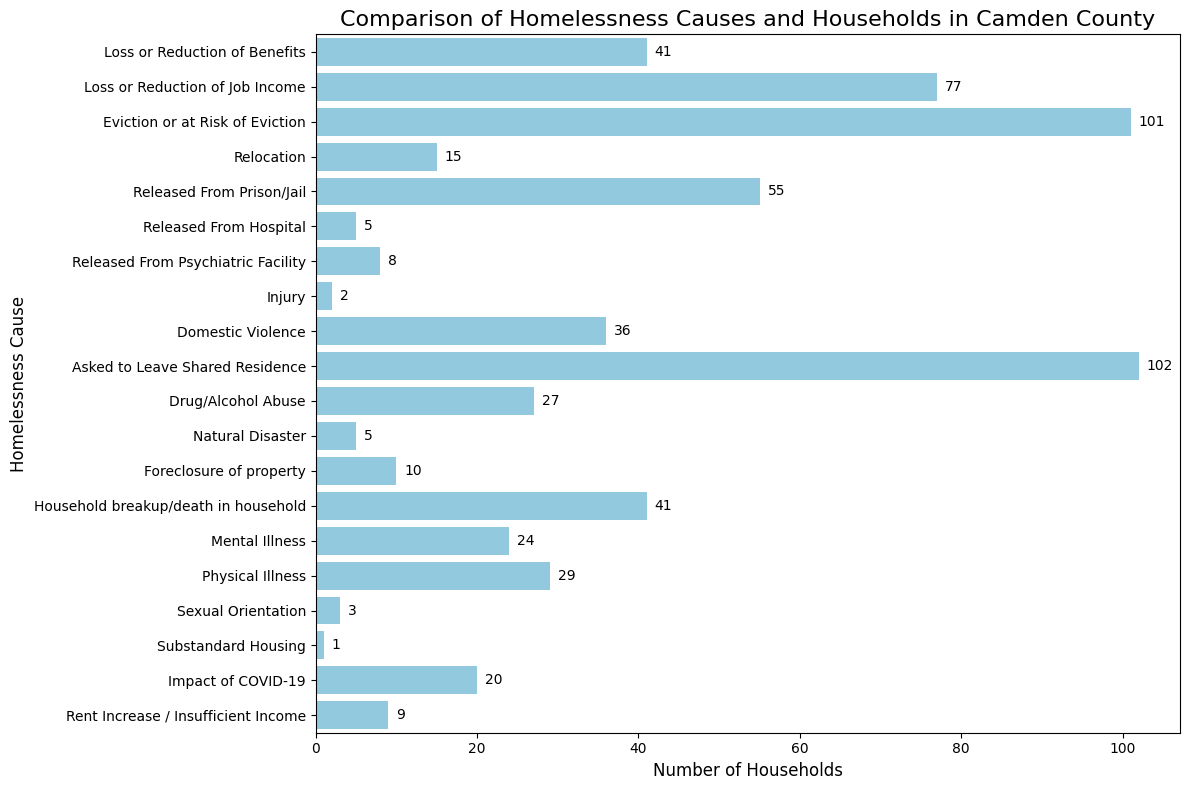

In [34]:
# Read the data from the provided URL
url = 'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/inus%20condition1.xlsx'
data = pd.read_excel(url)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart using Seaborn
sns.barplot(
    data=data,
    y='Homelessness Cause ',  # Causes on the Y-axis for better label alignment
    x='Households',
    color='skyblue'
)

# Add labels for each bar
for index, value in enumerate(data['Households']):
    plt.text(value + 1, index, f'{value}', va='center')  # Annotate each bar

# Customize the chart
plt.title('Comparison of Homelessness Causes and Households in Camden County', fontsize=16)
plt.xlabel('Number of Households', fontsize=12)
plt.ylabel('Homelessness Cause', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show();


Homelessness remains a significant challenge in Camden County, New Jersey, with ongoing debates about the origins of the homeless population. Some argue that many homeless individuals in Camden County are not originally from the area, yet evidence to support this claim is lacking. The 2024 Point-In-Time (PIT) count indicates that 244 of the homeless individuals counted in January 2024 were from Camden itself (Monarch Housing Associates, 2024).

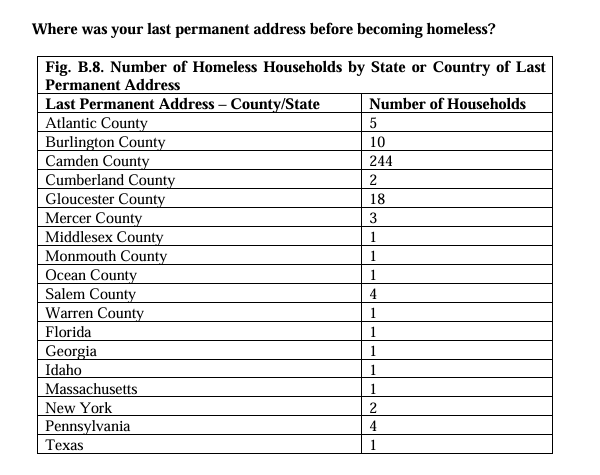

**Symbiotic Relationship Between Poverty and Homlessness across other New Jersey Counties.**

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


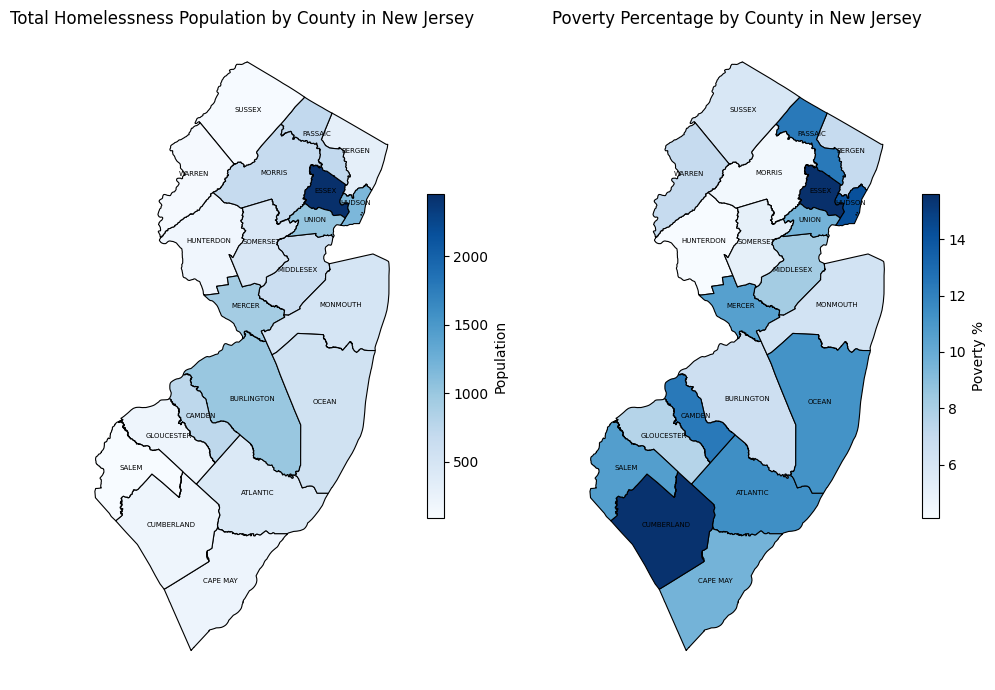

In [35]:


# Load New Jersey counties shapefile
url = "https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip"
counties = gpd.read_file(url)
nj_counties = counties[counties['STATEFP'] == '34']  # Filter for NJ (FIPS code = 34)

# Load and clean Chronicity data
Chronicity = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/chronic.xlsx')
Chronicity['COUNTY'] = Chronicity['County'].str.upper().str.strip()  # Standardize County names

# Clean NJ counties data and prepare for merge
nj_counties['NAME'] = nj_counties['NAME'].str.replace("County", "").str.strip().str.upper()
nj_counties['COUNTY'] = nj_counties['NAME']

# Merge NJ counties with Chronicity data
njMerged = nj_counties.merge(Chronicity, on='COUNTY', how='outer', indicator=True)

# Ensure columns for plotting (Population and Poverty) are numeric
njMerged['population'] = pd.to_numeric(njMerged['population'], errors='coerce')
njMerged['poverty'] = pd.to_numeric(njMerged['poverty'], errors='coerce')

# Plot maps
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

# First Map - Population by County
njMerged.plot(
    ax=axes[0], column='population', cmap='Blues',
    linewidth=0.8, edgecolor='black', legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Population'}
)
axes[0].set_title('Total Homelessness Population by County in New Jersey', fontsize=12)
axes[0].set_axis_off()

# Add county names on the first map (Population by County)
for _, row in njMerged.iterrows():
    centroid = row['geometry'].centroid
    axes[0].text(centroid.x, centroid.y, row['COUNTY'], fontsize=5, ha='center', color='black')

# Second Map - Poverty Percentage by County
njMerged.plot(
    ax=axes[1], column='poverty', cmap='Blues',
    linewidth=0.8, edgecolor='black', legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Poverty %'}
)
axes[1].set_title('Poverty Percentage by County in New Jersey', fontsize=12)
axes[1].set_axis_off()

# Add county names on the second map (Poverty Percentage by County)
for _, row in njMerged.iterrows():
    centroid = row['geometry'].centroid
    axes[1].text(centroid.x, centroid.y, row['COUNTY'], fontsize=5, ha='center', color='black')

# Adjust layout and show the plot
plt.tight_layout()
plt.show();


### 5-Year Comparison of Total Homeless Population by Housing Situation across Camden County, New Jersey



On the night of January 23, 2024, a total of 743 persons in 619 households were experiencing homelessness in Camden County. This Table shows that Camden County has seen an overall increase of 110 identified persons
(17%) from 2020 to 2024; and a gradual increase in population of unsheltered homeless persons between 2021 and 2024. (Monarch Housing, 2024).

This chart visualises patterns and trends of homlessness types over a period of 5 years. It also provides evidence-based recommendations for Shared Housing as a prevention and cure for homelessness in Camden County.

Index(['Year', 'Emergency Shelter', 'Unsheltered', 'Transitional Housing',
       'Safe Haven', 'Total'],
      dtype='object')


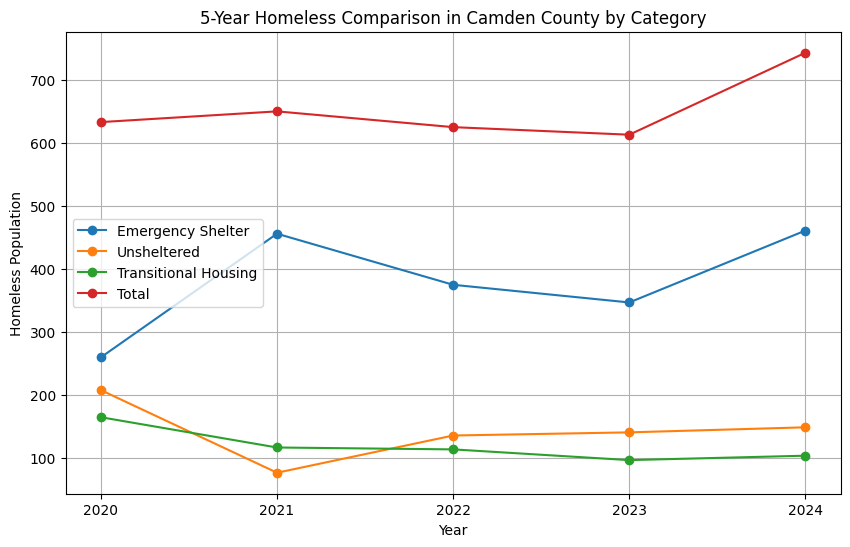

In [36]:

# Load the data from the raw Excel file
CountyFive = pd.read_excel('https://raw.githubusercontent.com/Funmiadebajo/GIS/main/5%20year%20homeless%20comparison.xlsx', engine='openpyxl')

# Strip whitespace from the column names
CountyFive.columns = CountyFive.columns.str.strip()

# Convert the 'Year' column to integers
CountyFive['Year'] = CountyFive['Year'].astype(int)

# Check the cleaned column names
print(CountyFive.columns)

# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Plot each category against the Year
plt.plot(CountyFive['Year'], CountyFive['Emergency Shelter'], marker='o', label='Emergency Shelter')
plt.plot(CountyFive['Year'], CountyFive['Unsheltered'], marker='o', label='Unsheltered')
plt.plot(CountyFive['Year'], CountyFive['Transitional Housing'], marker='o', label='Transitional Housing')
plt.plot(CountyFive['Year'], CountyFive['Total'], marker='o', label='Total')

# Set titles and labels
plt.title('5-Year Homeless Comparison in Camden County by Category')
plt.xlabel('Year')
plt.ylabel('Homeless Population')
plt.xticks(CountyFive['Year'])  # Set x-ticks to be the year values
plt.legend()
plt.grid(True)

# Show the plot
plt.show();


# Relationship Between Median Gross Rent and Homelssness in Camden County

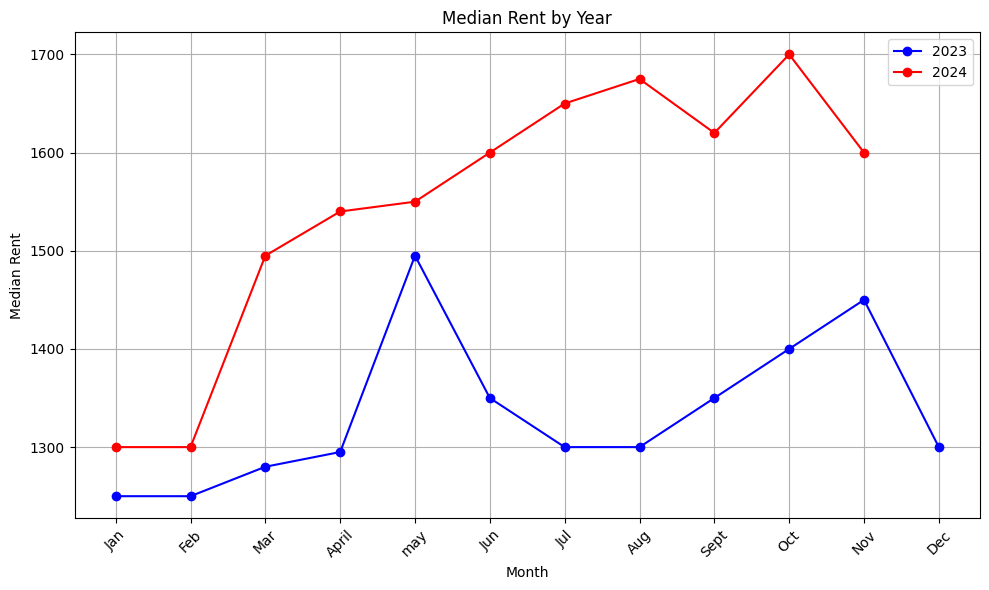

In [28]:

# Load the data from the provided URL
data = pd.read_excel('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/median%20rental%20by%20year.xlsx')

# Plot a line graph
plt.figure(figsize=(10, 6))

# Plotting '2023' and '2024' median rent values against 'Month' (use integer column names)
plt.plot(data['Month'], data[2023], marker='o', linestyle='-', color='b', label='2023')
plt.plot(data['Month'], data[2024], marker='o', linestyle='-', color='r', label='2024')

# Adding labels and title
plt.title('Median Rent by Year')
plt.xlabel('Month')
plt.ylabel('Median Rent')
plt.legend()

# Show the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the month labels for better readability
plt.tight_layout()
plt.show();


# Homelessness In Camden City, Camden NJ

Camden City is the critical intersection where high population, poverty, and homelessness converge. This indicates systemic socio-economic challenges in the area, where poverty significantly contributes to homelessness.

In my regression experiment, The Living in Poverty variable (coefficient: 0.1617, p-value: 0.728) shows a positive relationship with homelessness rates, suggesting that higher poverty rates are associated with increased homelessness. Although this relationship is not statistically significant at conventional levels, it aligns with existing literature on the connection between poverty and homelessness (Byrne et al., 2013). The lack of statistical significance may be due to the complex nature of homelessness, where poverty interacts with other factors to influence housing instability.
The White Alone variable demonstrates a statistically significant negative relationship with homelessness rates (coefficient: -0.5853, p-value: 0.016). This finding suggests that areas with higher percentages of White Alone population tend to have lower homelessness rates, which may reflect broader socioeconomic disparities and systemic inequalities (Olivet et al., 2021).
While the model indicates that educational attainment and racial composition have more statistically significant associations with homelessness rates than poverty levels, it's crucial to interpret these results cautiously. The relationship between poverty and homelessness is well-established in broader research (Shinn & Khadduri, 2020), and the lack of statistical significance in this particular model does not negate this connection. Instead, it highlights the need for more comprehensive analysis that considers the interplay between various socioeconomic factors and homelessness.

From the maps above, high population densities are observed in municipalities such as Camden City, Pennsauken Township, and Cherry Hill Township. These areas are urban centers or suburban regions with significant residential activity. However, the highest percentages of poverty are concentrated in Camden City, Pennsauken Township, and Merchantville Borough. This indicates a strong relationship between areas with high poverty rates and high population densities, particularly in Camden City.

Homelessness is heavily concentrated in Camden City, which aligns with its high poverty levels. This suggests that homelessness is not just linked to population density but is strongly driven by economic challenges, such as poverty.


In [69]:
njMun.head(10)

,FID,COUSUBNS,GEOID,Municipality,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,GEOCODE,GlobalID,Shape__Are,Shape__Len,geometry
0,1,00885144,3400702200,audubon,C5,F,3838781,35535,+39.8901277,-75.0723825,9407.757950,3400702200,81d661c6-35a7-42ed-8afd-5f35d0b0e807,3.871214e+06,9407.757866,"POLYGON ((495599.23 4415536.249, 495508.749 44..."
1,2,00885145,3400702230,audubon park,C5,F,389606,46935,+39.8968373,-75.0888190,2734.677596,3400702230,f8ccbea8-76dd-44e7-992b-e367d22e31a1,4.361934e+05,2734.677499,"POLYGON ((492866.221 4416337.872, 492855.687 4..."
2,3,00885149,3400703250,barrington,C5,F,4095340,0,+39.8689349,-75.0513618,11456.984021,3400703250,9e9086b1-16e4-429f-b5c4-d967de1dbd82,4.092067e+06,11456.984073,"POLYGON ((496819.374 4414558.505, 496827.878 4..."
3,4,00885154,3400704750,bellmawr,C5,F,7729295,315734,+39.8663560,-75.0946695,18085.471872,3400704750,bdd07346-3ee8-471e-befd-b8b9e16eb0a9,8.038608e+06,18085.472003,"POLYGON ((492951.896 4413667.751, 492968.147 4..."
4,5,00885158,3400705440,berlin borough,C5,F,9307767,35573,+39.7920594,-74.9369855,14823.777678,3400705440,032f4608-e579-4343-a5e1-7d3778ce56c5,9.335884e+06,14823.777540,"POLYGON ((507881.319 4403761.193, 507873.371 4..."
5,6,00882152,3400705470,berlin township,T1,A,8656740,15360,+39.8071159,-74.9241780,15771.555136,3400705470,e17a4101-16d7-4093-b9da-43f1044ceef7,8.665170e+06,15771.555122,"POLYGON ((507848.567 4406644.366, 507978.687 4..."
6,7,00885172,3400708170,brooklawn,C5,F,1265110,105763,+39.8793503,-75.1203958,5697.800517,3400708170,1e1a2ee3-3807-458d-8af0-7a2d5df7de30,1.369780e+06,5697.800436,"POLYGON ((490740.818 4414218.502, 490736.285 4..."
7,8,00885177,3400710000,camden,C5,F,23106182,3676392,+39.9367868,-75.1066438,28004.054276,3400710000,f5c8c982-1593-4592-a38a-485a23bd7d98,2.676122e+07,28004.054367,"POLYGON ((493032.266 4419551.728, 492897.768 4..."
8,9,00882155,3400712280,cherry hill,T1,A,62346260,321495,+39.9046107,-74.9969997,42634.513569,3400712280,561f8439-f9d9-47af-a877-f4c81e30fd7a,6.261764e+07,42634.513259,"POLYGON ((506224.674 4413748.279, 506174.32 44..."
9,10,00885183,3400712550,chesilhurst,C5,F,4442825,4000,+39.7297952,-74.8805311,9002.409548,3400712550,db06a511-84e0-41f6-a5d9-e8afa47e852f,4.443282e+06,9002.409554,"POLYGON ((512006.451 4397643.342, 512016.246 4..."


In [70]:
# Load and clean the New Jersey municipalities shapefile
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
# List of municipalities to keep unchanged
keep_unchanged = ["Berlin borough", "Berlin township", "Gloucester City", "Gloucester township"]

# Function to clean municipality names
def clean_municipality(name):
    name = name.strip()
    if name in keep_unchanged:
        return name
    if name == "Gloucester City city":
        return "Gloucester City"
    return ' '.join(word for word in name.split() if word.lower() not in ['borough', 'township'])

# Apply the cleaning function
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality)
njMun['Municipality'] = njMun['Municipality'].str.title()
print(njMun['Municipality'])

0                 Audubon
1            Audubon Park
2              Barrington
3                Bellmawr
4          Berlin Borough
5         Berlin Township
6               Brooklawn
7             Camden City
8             Cherry Hill
9             Chesilhurst
10              Clementon
11           Collingswood
12              Gibbsboro
13    Gloucester Township
14        Gloucester City
15                 Haddon
16            Haddonfield
17         Haddon Heights
18               Hi-Nella
19         Laurel Springs
20               Lawnside
21             Lindenwold
22               Magnolia
23          Merchantville
24          Mount Ephraim
25                 Oaklyn
26             Pennsauken
27              Pine Hill
28              Runnemede
29              Somerdale
30              Stratford
31              Tavistock
32               Voorhees
33              Waterford
34                Winslow
35              Woodlynne
Name: Municipality, dtype: object


In [41]:
research_data = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/research_data.csv')
research_data = research_data.rename(columns={'Municipality': 'ignore', 'Statistics': 'Municipality'})
#print(research_data.columns)
research_data.head(20)

,Municipality,Total Population,Total PIT Count,Homelessness per 10000,Unsheltered,White Alone,Black Alone,Asian Alone,High School Graduate,Bachelors Degree,...,Moved From Abroad,Vacant Units,Actual Renters,30 Percent Income As Rent,Mon Housing Cost,Median Gross Rent,2-Person Household,4-Person Household,7-or-More Person Household,ignore
0,Audubon,8695.0,3.0,3.450258769,0.0,93.9,2.4,0.2,27.2,27.6,...,0.0,4.8,9.9,20.0,42.7,1183.0,33.1,17.4,1.0,AUDUBON PARK BORO
1,Audubon Park,1031.0,0.0,0.0,0.0,93.2,1.3,0.0,54.8,11.9,...,0.0,3.4,1.0,15.6,20.7,941.0,22.7,9.0,0.0,AUDUBON PARK BORO
2,Barrington,7022.0,0.0,0.0,0.0,90.0,1.2,3.3,27.0,27.6,...,0.0,2.1,3.8,24.4,52.1,1247.0,36.5,6.7,0.0,BARRINGTON BORO
3,Bellmawr,11677.0,3.0,2.569153036,0.0,75.3,5.1,9.7,39.4,15.8,...,0.1,6.2,0.3,24.4,43.7,1081.0,25.6,12.3,1.5,BELLMAWR BORO
4,Berlin Borough,7489.0,0.0,0.0,0.0,77.0,12.5,0.7,27.7,26.1,...,0.0,5.7,4.4,4.6,40.8,1616.0,33.2,14.3,1.0,BERLIN BORO
5,Berlin Township,5881.0,0.0,0.0,0.7,68.1,5.3,6.9,37.2,19.8,...,0.0,4.2,4.0,48.7,60.5,1339.0,22.5,3.9,1.0,BERLIN BORO
6,Brooklawn,1894.0,2.0,10.55966209,0.0,77.5,11.3,6.8,39.1,10.8,...,0.0,11.3,9.2,14.9,37.5,1443.0,25.4,6.9,2.1,BROOKLAWN BORO
7,Camden City,71799.0,420.0,58.49663644,84.4,9.9,42.9,2.1,35.1,5.8,...,1.4,12.6,4.9,24.8,39.6,1091.0,24.4,14.3,3.0,CAMDEN CITY
8,Cherry Hill,74934.0,2.0,0.26690154,1.4,71.1,6.6,13.5,18.8,29.4,...,0.7,5.1,9.6,25.7,24.1,1726.0,33.8,15.8,0.9,CHERRY HILL TWP
9,Chesilhurst,1384.0,0.0,0.0,0.0,47.0,40.5,0.0,32.8,13.4,...,0.0,12.3,11.9,27.7,16.9,996.0,31.6,10.1,1.6,CHESILHURST BORO


**Load and Clean Data from Excel**

In [43]:
# Load and clean the New Jersey municipalities shapefile
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
# List of municipalities to keep unchanged
keep_unchanged = ["Berlin borough", "Berlin township", "Gloucester City", "Gloucester township"]

# Function to clean municipality names
def clean_municipality(name):
    name = name.strip()
    if name in keep_unchanged:
        return name
    if name == "Gloucester City city":
        return "Gloucester City"
    return ' '.join(word for word in name.split() if word.lower() not in ['borough', 'township'])

# Apply the cleaning function
njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality)
njMun['Municipality'] = njMun['Municipality'].str.title()
njMun.head(20)

,FID,COUSUBNS,GEOID,Municipality,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,GEOCODE,GlobalID,Shape__Are,Shape__Len,geometry
0,1,00885144,3400702200,Audubon,C5,F,3838781,35535,+39.8901277,-75.0723825,9407.757950,3400702200,81d661c6-35a7-42ed-8afd-5f35d0b0e807,3.871214e+06,9407.757866,"POLYGON ((495599.23 4415536.249, 495508.749 44..."
1,2,00885145,3400702230,Audubon Park,C5,F,389606,46935,+39.8968373,-75.0888190,2734.677596,3400702230,f8ccbea8-76dd-44e7-992b-e367d22e31a1,4.361934e+05,2734.677499,"POLYGON ((492866.221 4416337.872, 492855.687 4..."
2,3,00885149,3400703250,Barrington,C5,F,4095340,0,+39.8689349,-75.0513618,11456.984021,3400703250,9e9086b1-16e4-429f-b5c4-d967de1dbd82,4.092067e+06,11456.984073,"POLYGON ((496819.374 4414558.505, 496827.878 4..."
3,4,00885154,3400704750,Bellmawr,C5,F,7729295,315734,+39.8663560,-75.0946695,18085.471872,3400704750,bdd07346-3ee8-471e-befd-b8b9e16eb0a9,8.038608e+06,18085.472003,"POLYGON ((492951.896 4413667.751, 492968.147 4..."
4,5,00885158,3400705440,Berlin Borough,C5,F,9307767,35573,+39.7920594,-74.9369855,14823.777678,3400705440,032f4608-e579-4343-a5e1-7d3778ce56c5,9.335884e+06,14823.777540,"POLYGON ((507881.319 4403761.193, 507873.371 4..."
5,6,00882152,3400705470,Berlin Township,T1,A,8656740,15360,+39.8071159,-74.9241780,15771.555136,3400705470,e17a4101-16d7-4093-b9da-43f1044ceef7,8.665170e+06,15771.555122,"POLYGON ((507848.567 4406644.366, 507978.687 4..."
6,7,00885172,3400708170,Brooklawn,C5,F,1265110,105763,+39.8793503,-75.1203958,5697.800517,3400708170,1e1a2ee3-3807-458d-8af0-7a2d5df7de30,1.369780e+06,5697.800436,"POLYGON ((490740.818 4414218.502, 490736.285 4..."
7,8,00885177,3400710000,Camden City,C5,F,23106182,3676392,+39.9367868,-75.1066438,28004.054276,3400710000,f5c8c982-1593-4592-a38a-485a23bd7d98,2.676122e+07,28004.054367,"POLYGON ((493032.266 4419551.728, 492897.768 4..."
8,9,00882155,3400712280,Cherry Hill,T1,A,62346260,321495,+39.9046107,-74.9969997,42634.513569,3400712280,561f8439-f9d9-47af-a877-f4c81e30fd7a,6.261764e+07,42634.513259,"POLYGON ((506224.674 4413748.279, 506174.32 44..."
9,10,00885183,3400712550,Chesilhurst,C5,F,4442825,4000,+39.7297952,-74.8805311,9002.409548,3400712550,db06a511-84e0-41f6-a5d9-e8afa47e852f,4.443282e+06,9002.409554,"POLYGON ((512006.451 4397643.342, 512016.246 4..."


In [44]:
from shapely.validation import make_valid

# Step 1: Normalize keys for a consistent merge
njMun['Municipality'] = njMun['Municipality'].str.strip().str.lower()
research_data['Municipality'] = research_data['Municipality'].str.strip().str.lower()

# Step 2: Merge datasets with an outer join
merged_data = njMun.merge(research_data, on='Municipality', how='outer', indicator=True)

# Step 3: Validate geometries in `njMun`
merged_data['geometry'] = merged_data['geometry'].apply(lambda geom: make_valid(geom) if geom else None)

# Step 4: Convert numeric columns to proper dtypes (if applicable)
# Convert all non-geometry columns from research_data to numeric if possible
numeric_columns = research_data.columns.difference(['Municipality'])
for col in numeric_columns:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Step 5: Handle missing values
# Replace missing values in numeric columns with 0 for analysis
for col in numeric_columns:
    if col in merged_data.columns and merged_data[col].dtype in [float, int]:
        merged_data[col] = merged_data[col].fillna(0)

# Step 6: Handle missing geometries
# Fill missing geometries with empty geometries or exclude if not necessary
merged_data = merged_data[merged_data['geometry'].notnull()]

# Step 7: Reset the GeoDataFrame index
merged_data = merged_data.reset_index(drop=True)

# Step 8: (Optional) Compute centroids for easier plotting/labeling later
merged_data['centroid'] = merged_data['geometry'].centroid

merged_data['Municipality'] = merged_data['Municipality'].str.title()

# Step 9: Verify the merged dataset
print(merged_data.info())  # Summary of the merged data
print(merged_data.head())  # Preview the first few rows


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   FID                          36 non-null     int32   
 1   COUSUBNS                     36 non-null     object  
 2   GEOID                        36 non-null     object  
 3   Municipality                 36 non-null     object  
 4   CLASSFP                      36 non-null     object  
 5   FUNCSTAT                     36 non-null     object  
 6   ALAND                        36 non-null     int32   
 7   AWATER                       36 non-null     int32   
 8   INTPTLAT                     36 non-null     object  
 9   INTPTLON                     36 non-null     object  
 10  Shape_Leng                   36 non-null     float64 
 11  GEOCODE                      36 non-null     int64   
 12  GlobalID                     36 non-null     object  
 13 

In [45]:
merged_data.columns

Index(['FID', 'COUSUBNS', 'GEOID', 'Municipality', 'CLASSFP', 'FUNCSTAT',
       'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'Shape_Leng', 'GEOCODE',
       'GlobalID', 'Shape__Are', 'Shape__Len', 'geometry', 'Total Population',
       'Total PIT Count', 'Homelessness per 10000', 'Unsheltered',
       'White Alone', 'Black Alone', 'Asian Alone', 'High School Graduate',
       'Bachelors Degree', 'Unemployed', 'Living In Poverty',
       'Married Couple Family', 'Male Householder', 'Female Householder',
       'Single Parent Children', 'Median Household Income',
       'Moved Within Same County', 'Moved From Different County',
       'Moved From Different State', 'Moved From Abroad', 'Vacant Units',
       'Actual Renters', '30 Percent Income As Rent', 'Mon Housing Cost',
       'Median Gross Rent', '2-Person Household', '4-Person Household',
       '7-or-More Person Household', 'ignore', '_merge', 'centroid'],
      dtype='object')

<Axes: >

Text(0.5, 1.0, 'Total Population')

[]

[]

<Axes: >

Text(0.5, 1.0, 'Homelessness per 10000')

[]

[]

<Axes: >

Text(0.5, 1.0, 'Living In Poverty')

[]

[]

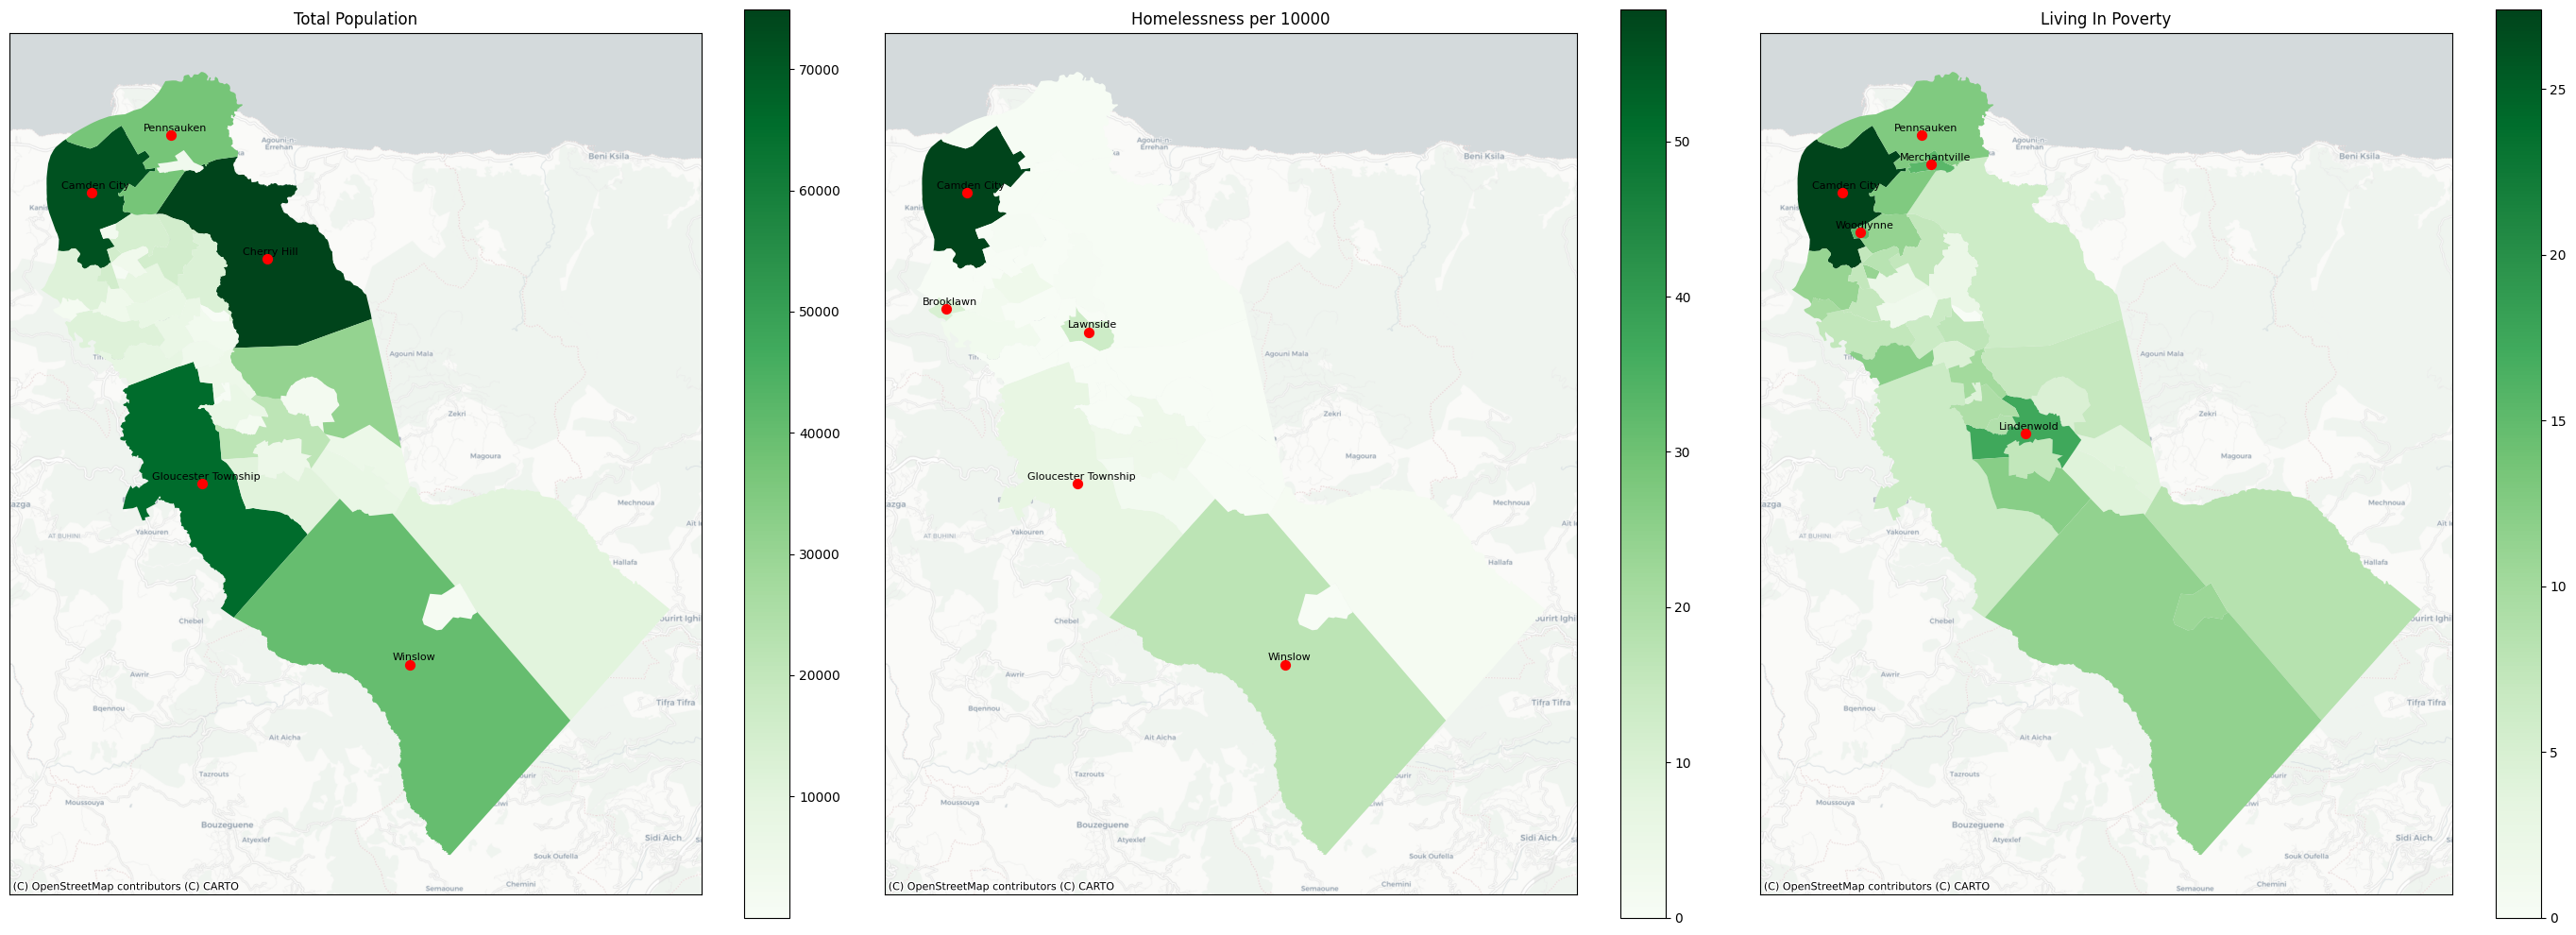

In [46]:
import contextily as cx

# Ensure geometry is projected to a suitable CRS (e.g., EPSG:3857 for web maps)
if not merged_data.crs or merged_data.crs.is_geographic:
    merged_data = merged_data.to_crs(epsg=3857)

# Convert relevant columns to numeric types, handling missing values
columns_to_numeric = [
    'Total Population',
    'Homelessness per 10000',
    'Living In Poverty',
]
for col in columns_to_numeric:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Drop rows where key metrics are NaN to ensure valid sorting and plotting
cleaned_data = merged_data.dropna(subset=columns_to_numeric, how='any')

# Get top 5 municipalities for each metric after ensuring numeric conversion
top_5_pop = cleaned_data.nlargest(5, 'Total Population')
top_5_homeless = cleaned_data.nlargest(5, 'Homelessness per 10000')
top_5_poverty = cleaned_data.nlargest(5, 'Living In Poverty')

# Function to annotate top 5 municipalities on each map
def annotate_top_5(ax, top_5_data):
    for idx, row in top_5_data.iterrows():
        # Ensure centroids are computed on valid geometries
        if row.geometry.is_valid:
            centroid = row.geometry.centroid
            ax.annotate(
                row['Municipality'],
                xy=(centroid.x, centroid.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
                ha='center',
                color='black'
            )
            ax.scatter(centroid.x, centroid.y, color='red', s=50, zorder=5)

fig, axes = plt.subplots(1, 3, figsize=(28, 10))

# Total Population
cleaned_data.plot(
    column='Total Population', cmap='Greens', legend=True, ax=axes[0],
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title('Total Population')
annotate_top_5(axes[0], top_5_pop)
cx.add_basemap(axes[0], source=cx.providers.CartoDB.Positron)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Homelessness per 10000
cleaned_data.plot(
    column='Homelessness per 10000', cmap='Greens', legend=True, ax=axes[1],
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title('Homelessness per 10000')
annotate_top_5(axes[1], top_5_homeless)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Living In Poverty
cleaned_data.plot(
    column='Living In Poverty', cmap='Greens', legend=True, ax=axes[2],
    missing_kwds={'color': 'lightgrey'}
)
axes[2].set_title('Living In Poverty')
annotate_top_5(axes[2], top_5_poverty)
cx.add_basemap(axes[2], source=cx.providers.CartoDB.Positron)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show()

# Homelessness as a function of income and housing Availability

This histogram portrays a diverse economic landscape within the county. The wide range of the histogram spanning from 180,000 DOllars highlights the income disparity within the county. The right skewed distribution signifies that most median household income are clustered around the lower end of the spectrum. The outliers are the few municipalities with median incomes exceeding 160,000 Doll. The peak of the histogram which falls between 60,000 and 80,000 indicates the most common median incomes across the county.

These numbers are vaulable for understanding the rental situation in correlation to homelss statistics.







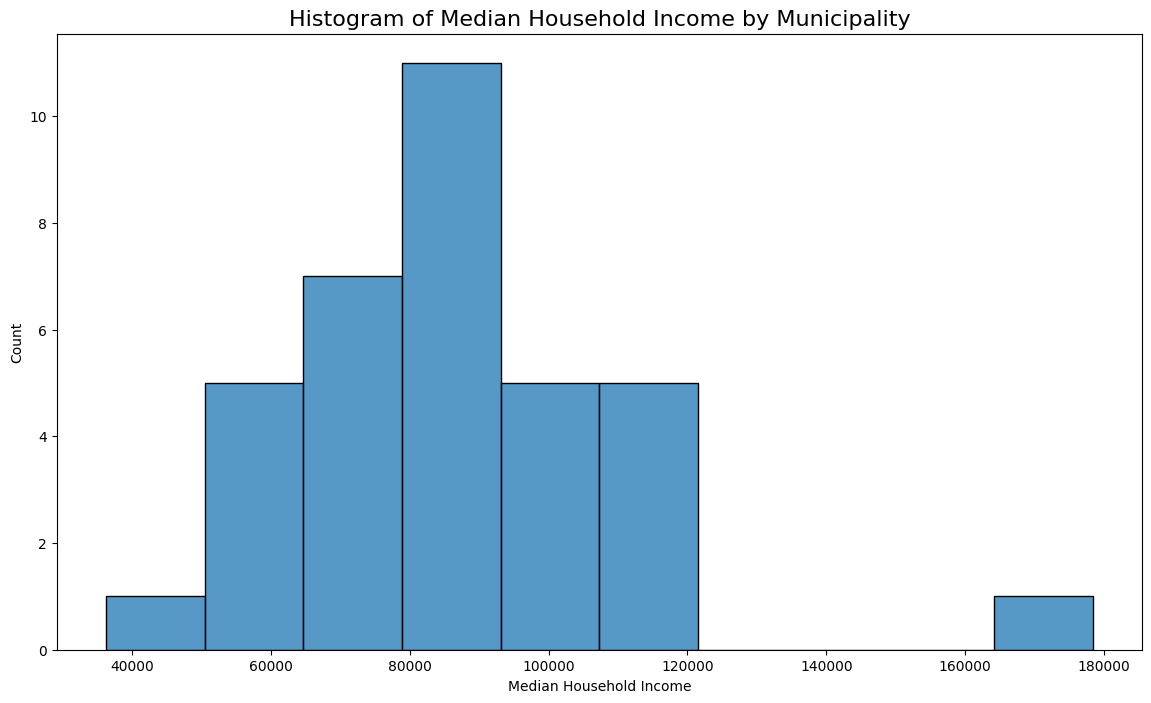

In [47]:
research_data = pd.read_csv('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/research_data.csv')
median_household_income = research_data['Median Household Income'].dropna()
plt.figure(figsize = (14, 8))
plt.title('Histogram of Median Household Income by Municipality', fontsize=16)
sns.histplot(median_household_income)
sns.set_style("darkgrid");

### **Relationship between Median Gross Rent, Actual Number of Renters and Total Vacancies**

These maps show the interaction between these three independent variables. it also provides a nuanced view of housing dynamics across the municipalities. for instance, the high vacancy rate and low numbers of renters in Camden City indicate a mismatch between housing availability and affordability. This also butresses conversations about demographic and economic conditions of the municipality. Potential renters are unable to rent due to their economic situation.  The combination of these factors contribute to housing instability and homelessness, as people struggle to find affordable rental options despite the availability of units.

This also points to a need for targeted policies that address both the affordability and quality of available rental housing to prevent further housing crises.










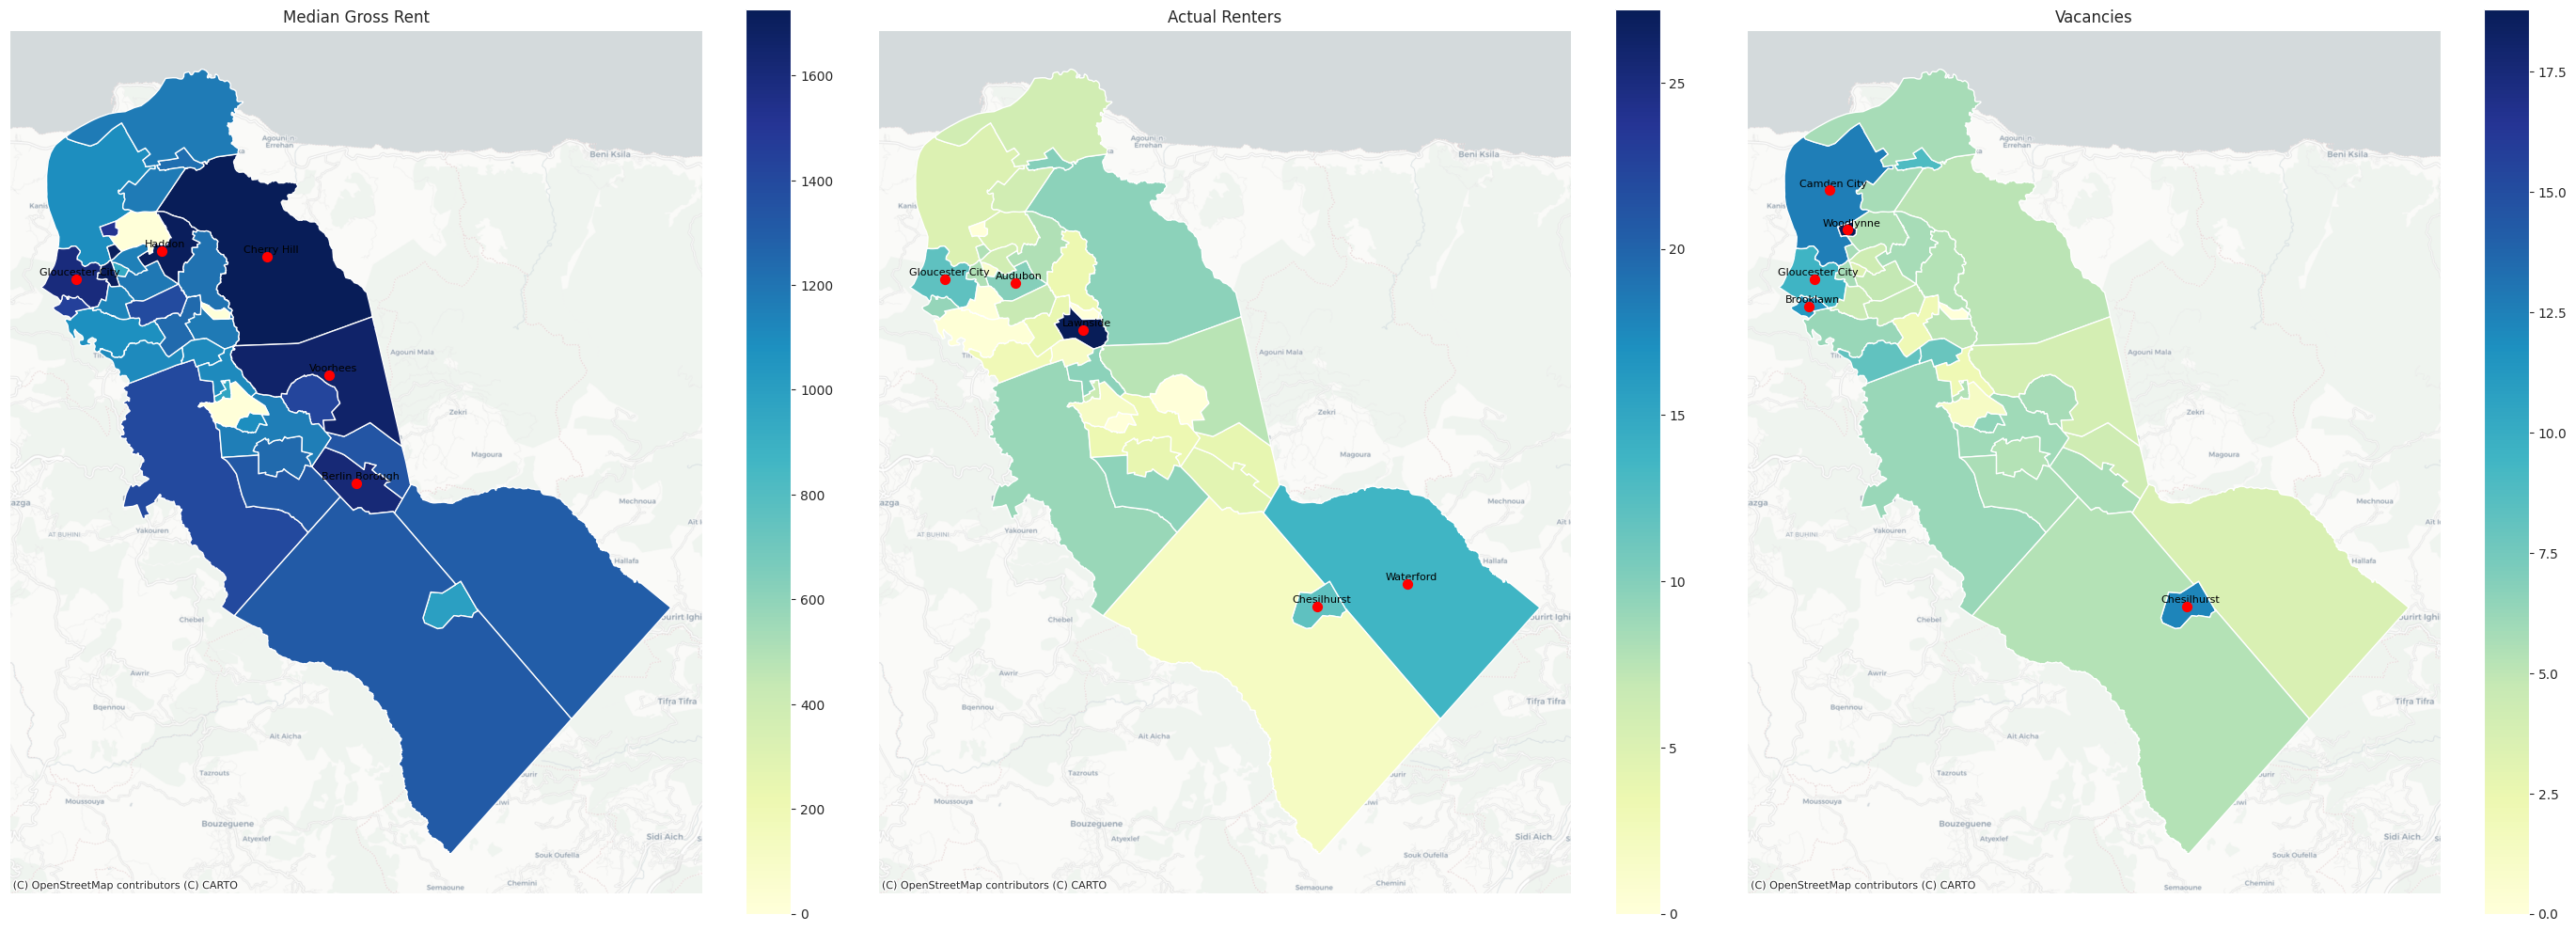

In [49]:
# Ensure geometry is projected to a suitable CRS (e.g., EPSG:3857 for web maps)
if not merged_data.crs or merged_data.crs.is_geographic:
    merged_data = merged_data.to_crs(epsg=3857)

# Convert relevant columns to numeric types, handling missing values
columns_to_numeric = [
    'Median Gross Rent',
    'Actual Renters',
    'Vacant Units'
]
for col in columns_to_numeric:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Drop rows where key metrics are NaN to ensure valid sorting and plotting
cleaned_data = merged_data.dropna(subset=columns_to_numeric, how='any')

# Get top 5 municipalities for each metric after ensuring numeric conversion
top_5_rent = cleaned_data.nlargest(5, 'Median Gross Rent')
top_5_actual_renters = cleaned_data.nlargest(5, 'Actual Renters')
top_5_vacancies = cleaned_data.nlargest(5, 'Vacant Units')

# Function to annotate top 5 municipalities on each map
def annotate_top_5(ax, top_5_data):
    for idx, row in top_5_data.iterrows():
        # Ensure centroids are computed on valid geometries
        if row.geometry.is_valid:
            centroid = row.geometry.centroid
            ax.annotate(
                row['Municipality'],
                xy=(centroid.x, centroid.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
                ha='center',
                color='black'
            )
            ax.scatter(centroid.x, centroid.y, color='red', s=50, zorder=5)

# Plot Task C: Median Gross Rent, Actual Renters, Vacancies
fig, axes = plt.subplots(1, 3, figsize=(28, 10))

# Median Gross Rent
cleaned_data.plot(
    column='Median Gross Rent', cmap='YlGnBu', legend=True, ax=axes[0],
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title("Median Gross Rent")
annotate_top_5(axes[0], top_5_rent)
cx.add_basemap(axes[0], source=cx.providers.CartoDB.Positron)
axes[0].set_xticks([])
axes[0].set_yticks([])

# Actual Renters
cleaned_data.plot(
    column='Actual Renters', cmap='YlGnBu', legend=True, ax=axes[1],
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title("Actual Renters")
annotate_top_5(axes[1], top_5_actual_renters)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Vacancies
cleaned_data.plot(
    column='Vacant Units', cmap='YlGnBu', legend=True, ax=axes[2],
    missing_kwds={'color': 'lightgrey'}
)
axes[2].set_title("Vacancies")
annotate_top_5(axes[2], top_5_vacancies)
cx.add_basemap(axes[2], source=cx.providers.CartoDB.Positron)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show();


# Relationship Between Median Household Income, 30 Percent Income As Rent, and Homelessness per 10,000 shows

These maps show how income levels and housing costs intersect to affect housing stability. The low median income and population of people payingmore than 30% of their income as rent in Camden City are key contributors to its increased homelessness rates, as individuals may struggle to afford housing.

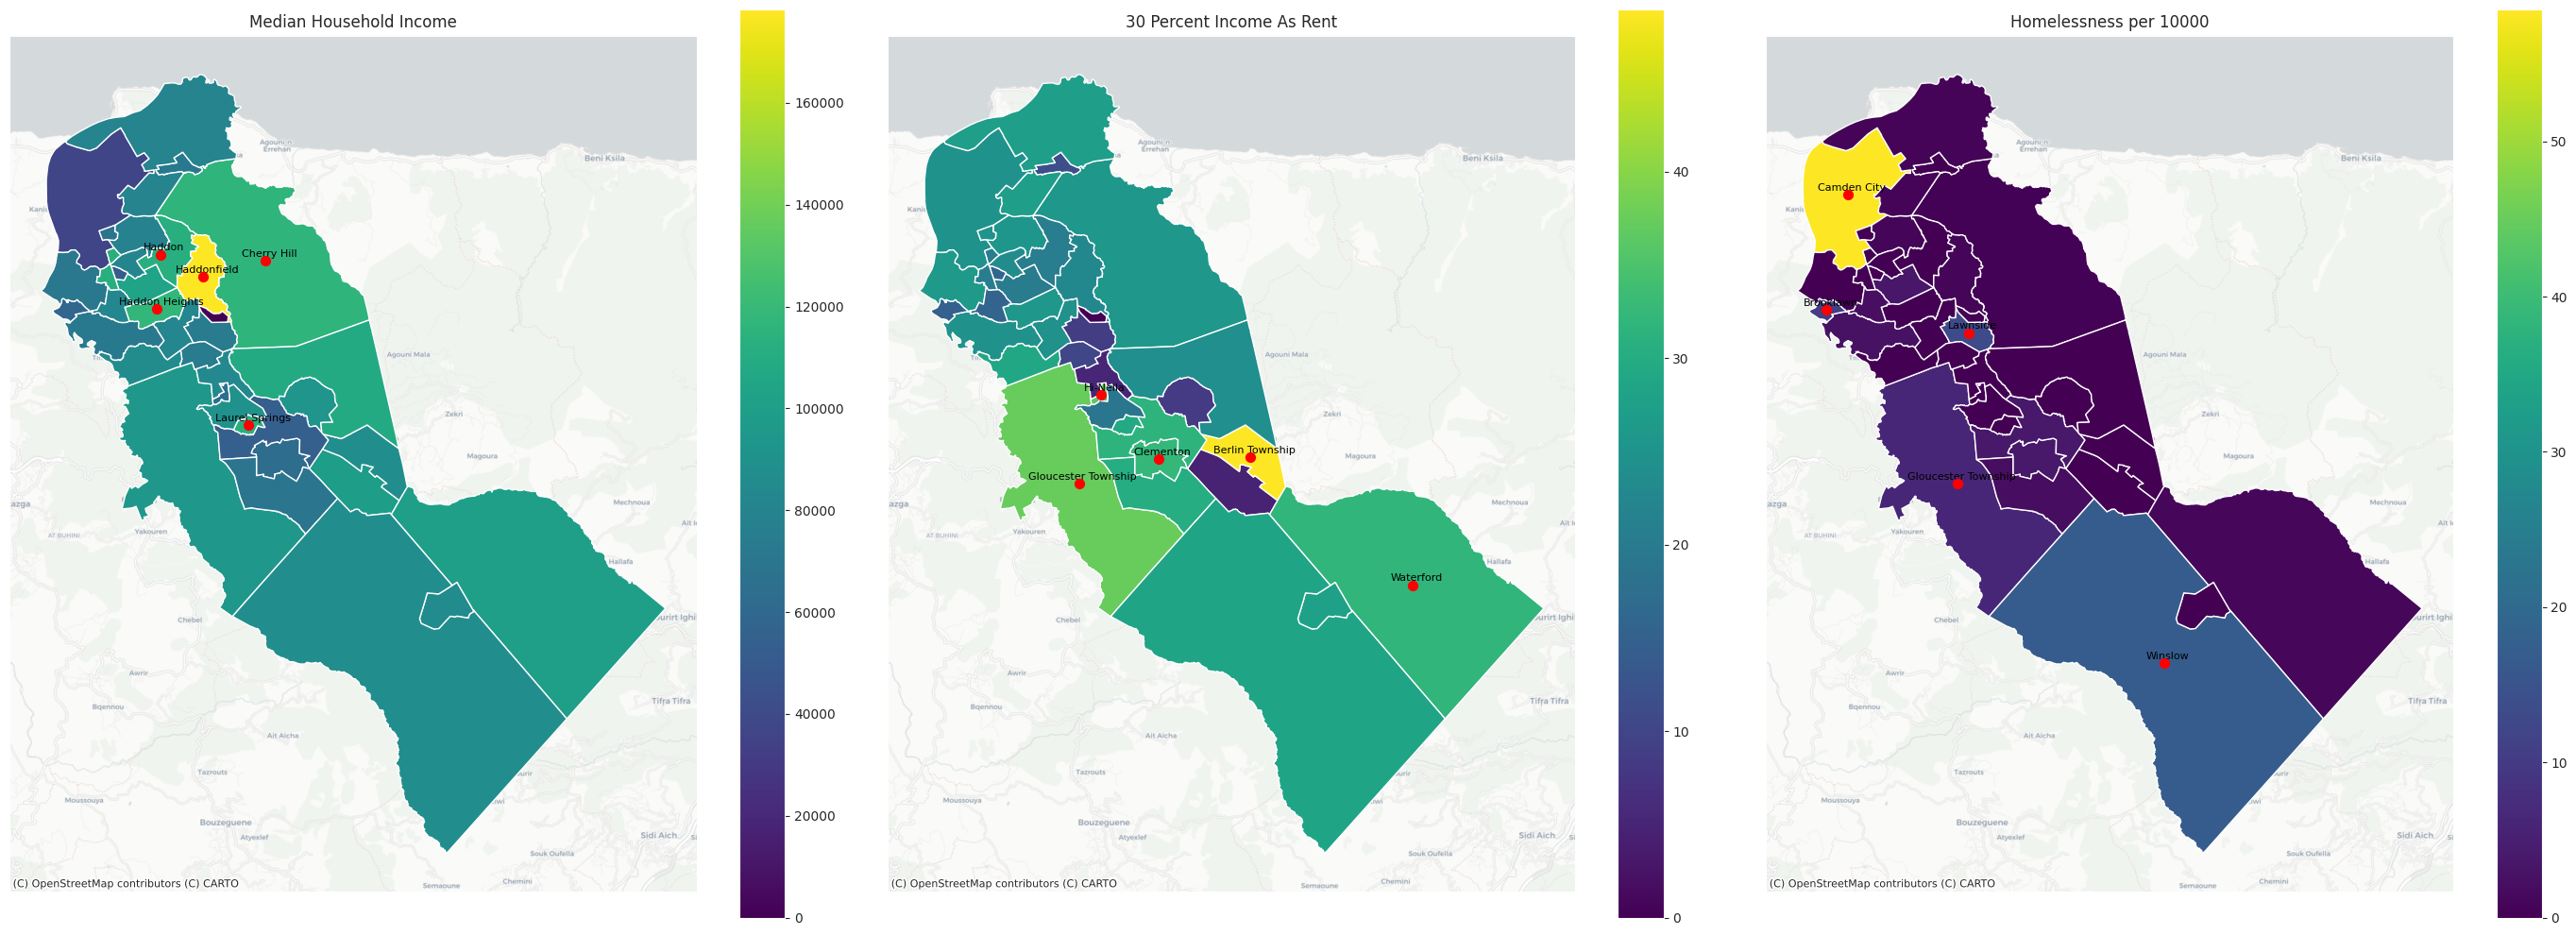

In [56]:
# Ensure geometry is projected to a suitable CRS (e.g., EPSG:3857 for web maps)
if not merged_data.crs or merged_data.crs.is_geographic:
    merged_data = merged_data.to_crs(epsg=3857)

# Convert relevant columns to numeric types, handling missing values
columns_to_numeric = [
    'Median Household Income',
    '30 Percent Income As Rent',
    'Homelessness per 10000'
]
for col in columns_to_numeric:
    if col in merged_data.columns:
        merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Drop rows where key metrics are NaN to ensure valid sorting and plotting
cleaned_data = merged_data.dropna(subset=columns_to_numeric, how='any')

# Get top 5 municipalities for each metric after ensuring numeric conversion
top_5_income = cleaned_data.nlargest(5, 'Median Household Income')
top_5_rent_burden = cleaned_data.nlargest(5, '30 Percent Income As Rent')
top_5_homelessness = cleaned_data.nlargest(5, 'Homelessness per 10000')

# Function to annotate top 5 municipalities on each map
def annotate_top_5(ax, top_5_data):
    for idx, row in top_5_data.iterrows():
        # Ensure centroids are computed on valid geometries
        if row.geometry.is_valid:
            centroid = row.geometry.centroid
            ax.annotate(
                row['Municipality'],
                xy=(centroid.x, centroid.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=8,
                ha='center',
                color='black'
            )
            ax.scatter(centroid.x, centroid.y, color='red', s=50, zorder=5)

# Plot Task C: Median Household Income, 30 Percent Income As Rent, Homelessness per 10,000
fig, axes = plt.subplots(1, 3, figsize=(28, 10))

# Median Household Income
cleaned_data.plot(
    column='Median Household Income', cmap='viridis', legend=True, ax=axes[0],
    missing_kwds={'color': 'lightgrey'}
)
axes[0].set_title("Median Household Income")
annotate_top_5(axes[0], top_5_income)
cx.add_basemap(axes[0], source=cx.providers.CartoDB.Positron)
axes[0].set_xticks([])
axes[0].set_yticks([])

# 30 Percent Income As Rent
cleaned_data.plot(
    column='30 Percent Income As Rent', cmap='viridis', legend=True, ax=axes[1],
    missing_kwds={'color': 'lightgrey'}
)
axes[1].set_title("30 Percent Income As Rent")
annotate_top_5(axes[1], top_5_rent_burden)
cx.add_basemap(axes[1], source=cx.providers.CartoDB.Positron)
axes[1].set_xticks([])
axes[1].set_yticks([])

# Homelessness per 10000
cleaned_data.plot(
    column='Homelessness per 10000', cmap='viridis', legend=True, ax=axes[2],
    missing_kwds={'color': 'lightgrey'}
)
axes[2].set_title("Homelessness per 10000")
annotate_top_5(axes[2], top_5_homelessness)
cx.add_basemap(axes[2], source=cx.providers.CartoDB.Positron)
axes[2].set_xticks([])
axes[2].set_yticks([])

plt.tight_layout()
plt.show();


**ASCERTAINING THE FEASIBILITY AND ACCEPTANCE OF SHARED HOUSING IN CAMDEN NJ**

Critics of shared housing argue that it may not be effective for certain populations due to cultural and personal factors, especially in societies with a strong emphasis on individualism, like the United States. However, due to increasing housing costs, shared housing seems to be on the rise as seen in this chart.   



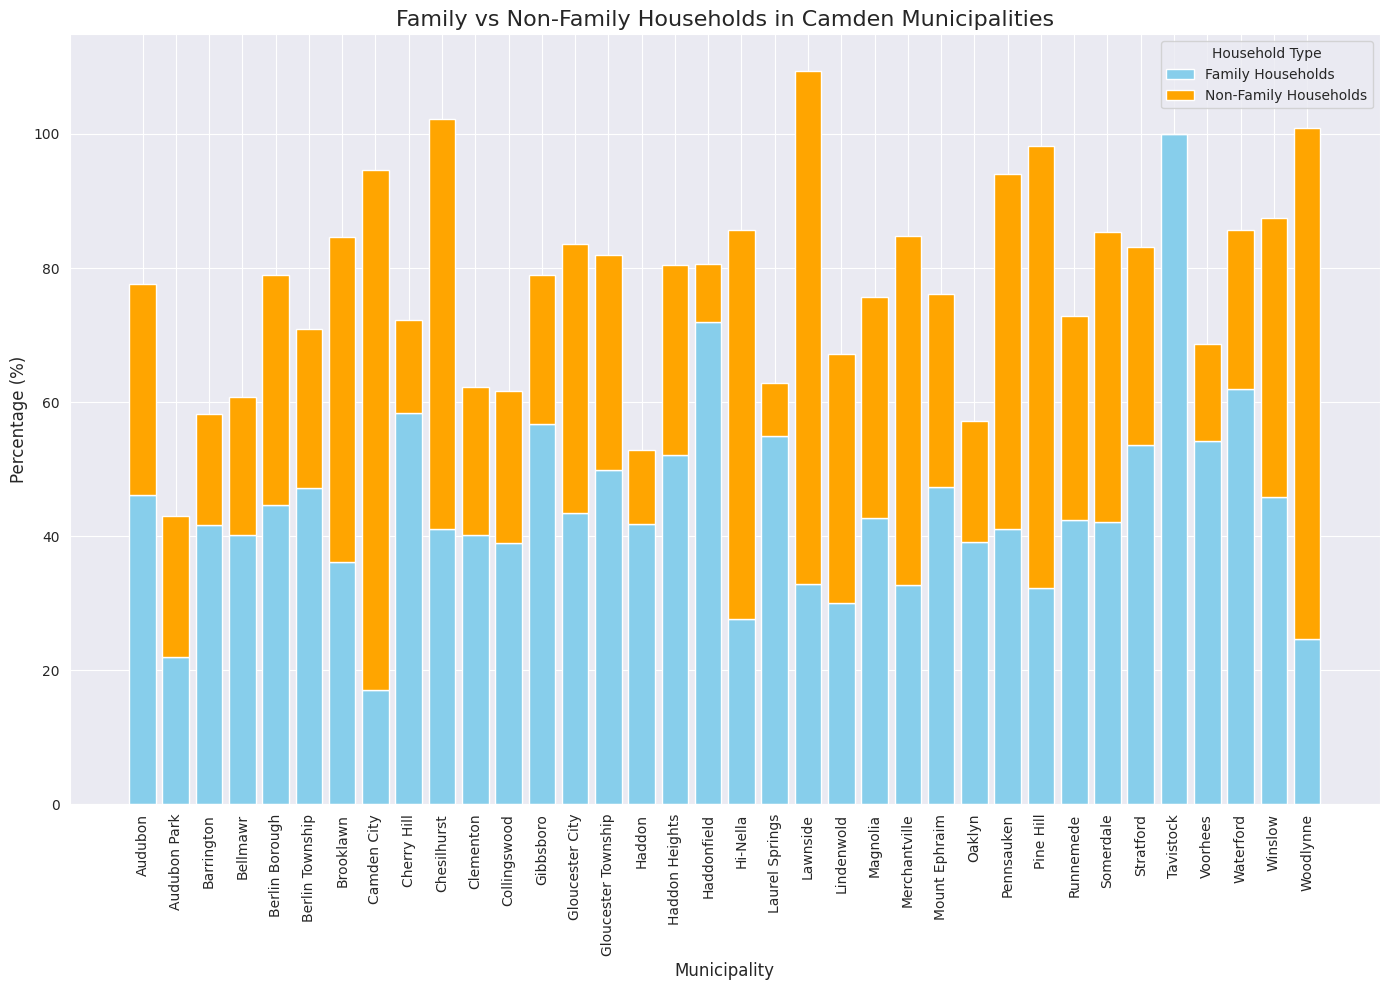

In [59]:
fig, ax = plt.subplots(figsize=(14, 10))

# Data
municipalities = merged_data['Municipality']
family_households = merged_data['Married Couple Family']
nonfamily_households = merged_data['Single Parent Children']

# Plot Family Households
ax.bar(
    municipalities, family_households, label='Family Households',
    color='skyblue', width=0.8
)

# Plot Non-Family Households (stacked on top)
ax.bar(
    municipalities, nonfamily_households, bottom=family_households,
    label='Non-Family Households', color='orange', width=0.8
)

# Add labels and title
ax.set_xlabel('Municipality', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Family vs Non-Family Households in Camden Municipalities', fontsize=16)
ax.legend(title="Household Type", fontsize=10)

# Customize x-axis
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show();


<Figure size 1400x700 with 0 Axes>

<Axes: xlabel='Move Value', ylabel='Median Gross Rent'>

Text(0.5, 1.0, 'Scatter Plot of Foreign-Born Population vs Median Gross Rent')

Text(0.5, 0, 'Move Value (%)')

Text(0, 0.5, 'Median Gross Rent')

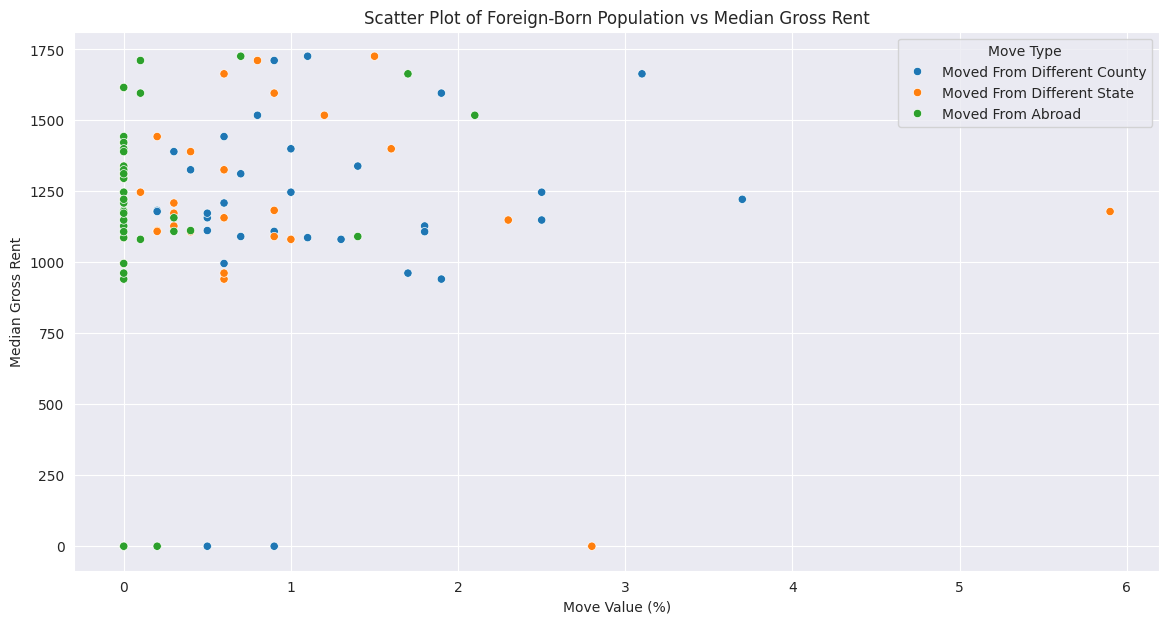

In [60]:
melted_data = pd.melt(
    merged_data,
    id_vars=['Median Gross Rent'],  # The y-axis variable remains unchanged
    value_vars=['Moved From Different County', 'Moved From Different State', 'Moved From Abroad'],
    var_name='Move Type',  # New column for x-axis variable names
    value_name='Move Value'  # New column for the values of the x-axis
)

# Create the scatter plot
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x='Move Value',
    y='Median Gross Rent',
    hue='Move Type',  # Optional: differentiates points by the move type
    data=melted_data
)

plt.title('Scatter Plot of Foreign-Born Population vs Median Gross Rent')
plt.xlabel('Move Value (%)')
plt.ylabel('Median Gross Rent')
plt.legend(title='Move Type')
plt.show()

# OLS Regressions

# **Economic and Demographic Determinants of Homelessness**

In [62]:
import statsmodels.api as sm

# Regression 1: Economic and Demographic Determinants of Homelessness
X1 = merged_data[['White Alone', 'Black Alone', 'Asian Alone', 'High School Graduate', 'Married Couple Family', 'Male Householder',
                  'Female Householder', 'Single Parent Children', 'Living In Poverty', 'Median Household Income']]
y1 = merged_data['Homelessness per 10000']

# Add constant to the model (for intercept)
X1 = sm.add_constant(X1)

# Perform OLS Regression
model1 = sm.OLS(y1, X1).fit()

# Display Regression Tables (Summaries)
print("Regression 1 Summary:")
print(model1.summary())


Regression 1 Summary:
                              OLS Regression Results                              
Dep. Variable:     Homelessness per 10000   R-squared:                       0.537
Model:                                OLS   Adj. R-squared:                  0.352
Method:                     Least Squares   F-statistic:                     2.903
Date:                    Tue, 26 Nov 2024   Prob (F-statistic):             0.0149
Time:                            19:11:05   Log-Likelihood:                -120.31
No. Observations:                      36   AIC:                             262.6
Df Residuals:                          25   BIC:                             280.0
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

# **Housing Affordability and Geographic Mobility as Determinants of Homelessness**

In [63]:
# Regression 2: Housing Affordability and Geographic Mobility as Determinants of Homelessness
X2 = merged_data[['Median Household Income', 'Actual Renters', '30 Percent Income As Rent', 'Mon Housing Cost', 'Median Gross Rent',
                  'Vacant Units', 'Moved Within Same County', 'Moved From Different County', 'Moved From Different State', 'Moved From Abroad']]
y2 = merged_data['30 Percent Income As Rent']

# Add constant to the model (for intercept)
X2 = sm.add_constant(X2)

# Perform OLS Regression
model2 = sm.OLS(y2, X2).fit()
print("\nRegression 2 Summary:")
print(model2.summary())


Regression 2 Summary:
                                OLS Regression Results                               
Dep. Variable:     30 Percent Income As Rent   R-squared:                       1.000
Model:                                   OLS   Adj. R-squared:                  1.000
Method:                        Least Squares   F-statistic:                 1.097e+28
Date:                       Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                               19:18:06   Log-Likelihood:                 1011.6
No. Observations:                         36   AIC:                            -2001.
Df Residuals:                             25   BIC:                            -1984.
Df Model:                                 10                                         
Covariance Type:                   nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------

# Homelessness vs. Geographic Mobility

There has been a lot of conversation about gentrification in Camden City and it's role in housing affrodability and subsequently, homelssness. but my research shoed that there's not as much gentrification in Camden City as portrayed.

Camden City's high homelessness rate can be attributed to a complex interplay of factors, with geographic mobility playing a significant role. The city's unique migration patterns contribute to its housing instability and homelessness challenges. Camden ranks third in the percentage of its population that moved from abroad (1.7%) and fifth in intra-county movement, indicating a high level of population influx.

The positive relationship between immigration and homelessness correlates with increased homelessness rates. This suggests that newcomers to Camden face significant barriers in securing stable housing

Furthermore, Camden's high rate of intra-county movement indicates a dynamic local housing market,based on it very low housing cost. in contrast, this can lead to increased competition for affordable housing and potentially drive up costs

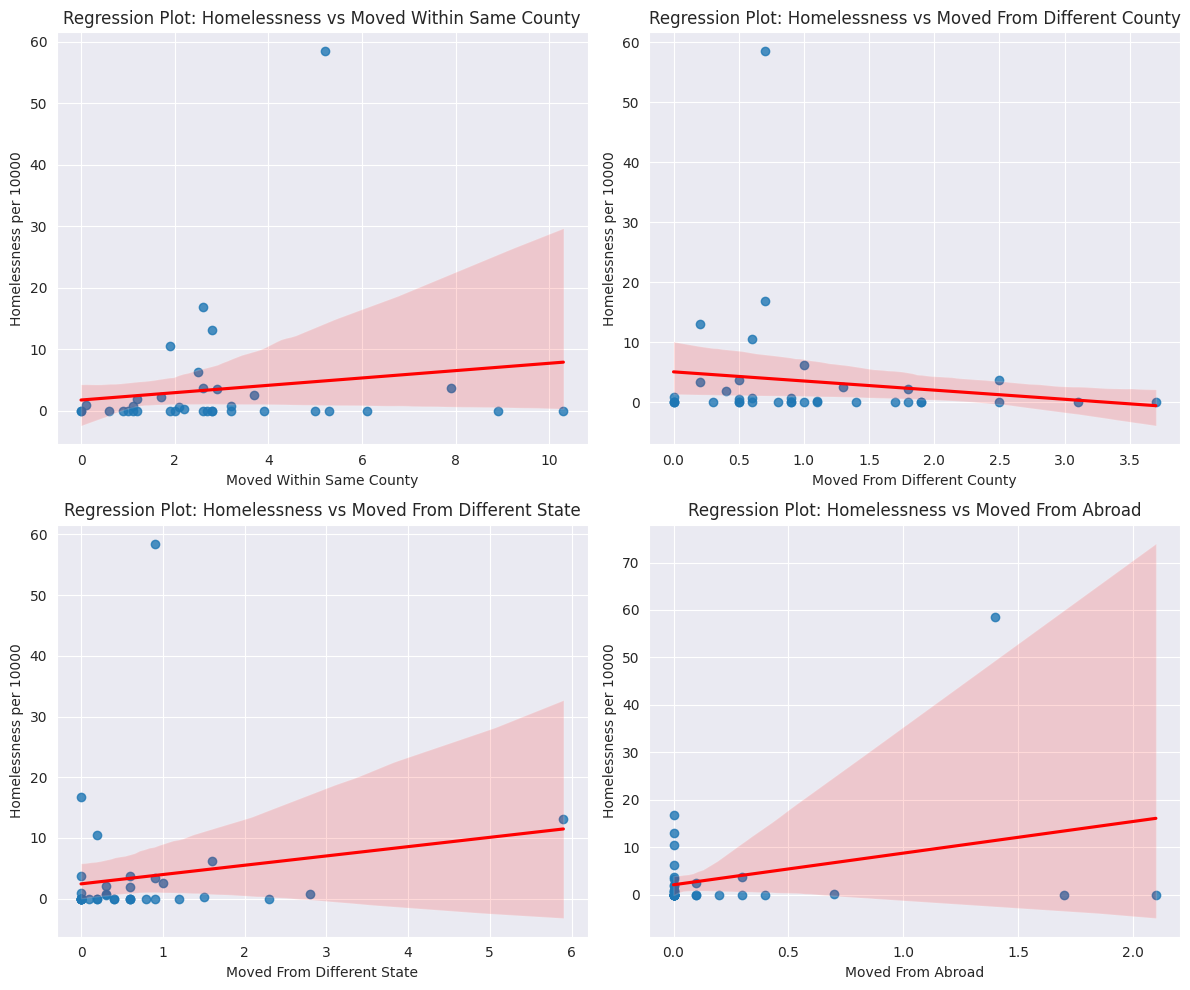

In [65]:
# Scatterplot of Homelessness vs Geographic Movement

independent_vars = ['Moved Within Same County', 'Moved From Different County',
                    'Moved From Different State', 'Moved From Abroad']

# Create a 2x2 grid for the plots (since we have 4 variables)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 grid into 1D for easy iteration

# Loop through each variable and create a regression plot
for i, var in enumerate(independent_vars):
    sns.regplot(x=merged_data[var], y=merged_data['Homelessness per 10000'],
                ax=axes[i], line_kws={'color': 'red'})
    axes[i].set_title(f'Regression Plot: Homelessness vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Homelessness per 10000')

# Adjust layout and show all plots in one image
plt.tight_layout()
plt.show();


# Homelessness vs. Family Structure

Married Couple Families: The clear negative slope, shows that higher rates of married couple families are associated with lower homelessness. This could suggest that stable family structures provide economic and social support, reducing homelessness.

Male and Female Householders: The slight positive trend indicates that male-headed households may be correlated with high rates of homelessness, but much lesser than the rates associated with female Householder's scatterplot which reveals a stronger positive relationship. This potentially due to single-parent economic challenges.Female-headed households seem more vulnerable to homelessness, highlighting the intersection of poverty, caregiving roles, and gender inequities.

Single Parent Children: A positive slope suggests a strong relationship between the number of single-parent children and homelessness rates. This underscores how family instability can lead to economic vulnerability.

<Axes: xlabel='Married Couple Family', ylabel='Homelessness per 10000'>

Text(0.5, 1.0, 'Regression Plot: Homelessness vs Married Couple Family')

Text(0.5, 0, 'Married Couple Family')

Text(0, 0.5, 'Homelessness per 10000')

<Axes: xlabel='Male Householder', ylabel='Homelessness per 10000'>

Text(0.5, 1.0, 'Regression Plot: Homelessness vs Male Householder')

Text(0.5, 0, 'Male Householder')

Text(0, 0.5, 'Homelessness per 10000')

<Axes: xlabel='Female Householder', ylabel='Homelessness per 10000'>

Text(0.5, 1.0, 'Regression Plot: Homelessness vs Female Householder')

Text(0.5, 0, 'Female Householder')

Text(0, 0.5, 'Homelessness per 10000')

<Axes: xlabel='Single Parent Children', ylabel='Homelessness per 10000'>

Text(0.5, 1.0, 'Regression Plot: Homelessness vs Single Parent Children')

Text(0.5, 0, 'Single Parent Children')

Text(0, 0.5, 'Homelessness per 10000')

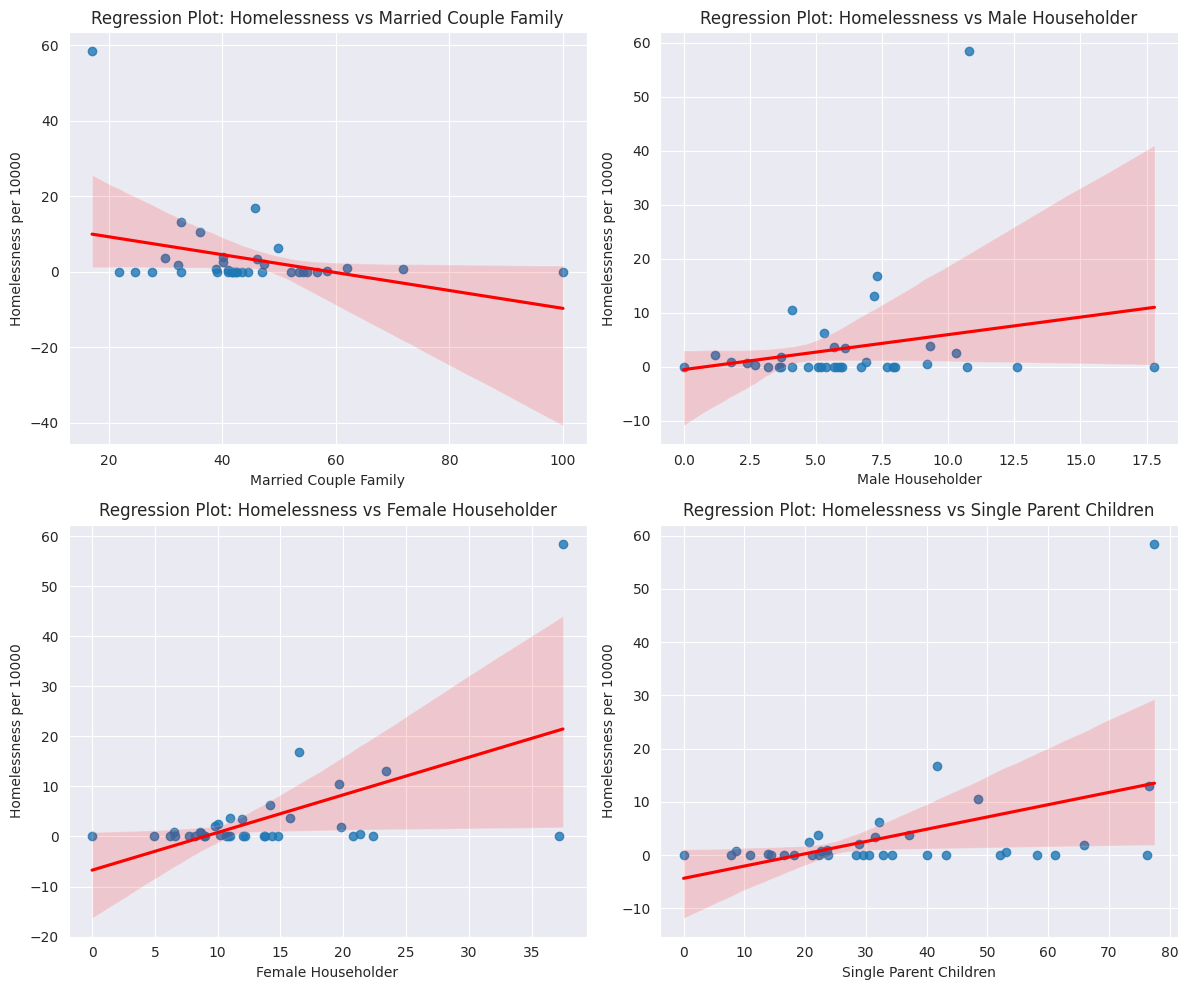

In [66]:
# Scatterplot of Homelessness vs Household Type
independent_vars = ['Married Couple Family', 'Male Householder',
                    'Female Householder', 'Single Parent Children']

# Create a 2x2 grid for the plots (since we have 4 variables)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 grid into 1D for easy iteration

# Loop through each variable and create a regression plot
for i, var in enumerate(independent_vars):
    sns.regplot(x=merged_data[var], y=merged_data['Homelessness per 10000'],
                ax=axes[i], line_kws={'color': 'red'})
    axes[i].set_title(f'Regression Plot: Homelessness vs {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Homelessness per 10000')

# Adjust layout and show all plots in one image
plt.tight_layout()
plt.show()

In [67]:
import geopandas as gpd
# Load municipality data and clean names
njMun = gpd.read_file('https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/Municipality.zip')
njMun.rename(columns={'NAMELSAD': 'Municipality'}, inplace=True)
njMun.loc[:, 'Municipality'] = njMun['Municipality'].str.strip().str.lower()

# Standardize and remove suffixes from municipality names but preserve Berlin distinctions
def clean_municipality_name(name):
    if 'berlin borough' in name or 'berlin township' in name:
        return name.lower().strip()
    # Clean other municipality names
    return re.sub(r'\s(borough|township|city|village|town)$', '', name, flags=re.IGNORECASE).strip().lower()

njMun['Municipality'] = njMun['Municipality'].apply(clean_municipality_name)


In [ ]:
print(njMun[njMun['Municipality'].str.contains('Berlin')])


**HOUSING AND INCOME AS INUS CONDITION FOR HOMELESSNESS**

In the context of homelessness, housing and income can act individually and collectively as Insufficient but Necessary parts of Unnecessary but Sufficient conditions that contribute to Homelessness. Alone, neither of them as necessarily causes homelessness, as individuals may have support systems or temporary aids such as Housing Assistance, and other social safety nets. This Bar Chart shows how other risk factors, when interacting, significantly increases the vulnerability to homelessness, and each factor could be necessary within a particular combination but not sufficient on its own.

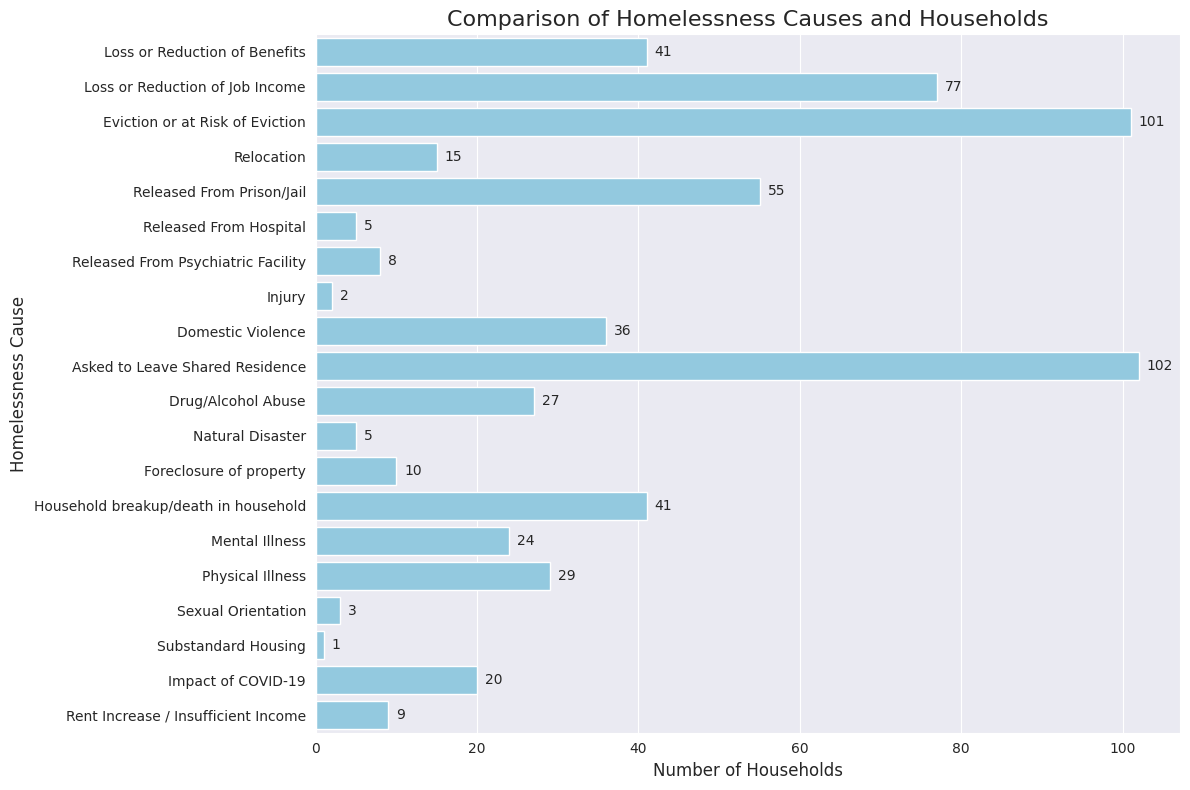

In [68]:
# Read the data from the provided URL
url = 'https://github.com/Funmiadebajo/GIS/raw/refs/heads/main/inus%20condition1.xlsx'
data = pd.read_excel(url)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create a horizontal bar chart using Seaborn
sns.barplot(
    data=data,
    y='Homelessness Cause ',  # Causes on the Y-axis for better label alignment
    x='Households',
    color='skyblue'
)

# Add labels for each bar
for index, value in enumerate(data['Households']):
    plt.text(value + 1, index, f'{value}', va='center')  # Annotate each bar

# Customize the chart
plt.title('Comparison of Homelessness Causes and Households', fontsize=16)
plt.xlabel('Number of Households', fontsize=12)
plt.ylabel('Homelessness Cause', fontsize=12)
plt.tight_layout()

# Show the plot
plt.show();


# FIndings from Literature Review on Shared Housing

In a research by Yinghua et. al. (2008), over a one year period it was found that shared housing does not appear to affect its users adversely
in most of the dimensions we examined. On the contrary,
in some dimensions it appears to help. Sharing at
3 months is associated with less psychotic symptomology
at12 months. The idea that sharing reduces psychoticsymptomology
has intuitive appeal. Isolation leads people to
dwell on their own internal thinking, while having contact
with others fosters a focus on the interpersonal socialized
world.


# Policy Limitations of Shared Housing

In this research of shared housing as a solutionto homelessness in Camden City, three core policy limitations have been identified as barrierrs to the implementation of shared Housing. These are zoning laws, implicit taxes, and concerns over adverse possession.

**Zoning laws** are a major obstacle to shared housing because they typically restrict the types of housing that can be developed in certain areas. Many regions only allow single-family homes, which limits the potential for diverse housing solutions such as multi-family or shared housing units (Fischel, 2001). This exclusionary zoning practice not only prevents lower-income individuals from accessing neighborhoods with better resources but also exacerbates existing housing inequalities (Glaeser, 2017). New Jersey has attempted reforms—like the Mount Laurel decision however, these efforts are often hampered by other restrictions such as limits on building size (Ellen & McCabe, 2018).

**Implicit Taxes**
Implicit taxes present another challenge by imposing financial burdens on property owners who might otherwise consider shared housing arrangements. These can include higher property taxes or additional fees for multi-family units, which increase the cost of offering shared living spaces (O'Sullivan, 2018). Such financial disincentives make shared housing less attractive to landlords, especially when the economic benefits are uncertain.

**Adverse Possession**
Adverse possession allows someone to claim ownership of a property after residing there for an extended period (typically 10-20 years, depending on the state). This can discourage property owners from engaging in long-term shared housing programs. As a result, many property owners are reluctant to engage in shared housing due to the perceived risk of losing control over their assets.


# **Recommendations**


**Landlord engagement as a tool to promote shared housing despite policy limitations**


Engaging landlords is a straightforward and cost-effective strategy to expand shared housing opportunities.

Financial incentives such as lower property taxes or guaranteed rent payment through the Tenant Rental Agreement and  housing vouchers can can help offset perceived risks associated with renting to multiple tenants while laso encourage them to participate in shared housing programs.

Education and support: Providing landlords with training and resources on shared housing can help them understand the benefits and address concerns. This includes workshops on tenant-landlord laws, conflict resolution, and strategies for fostering positive relationships between roommates.

Roommate matching services: Housing organizations can facilitate roommate pairing to reduce housing costs and increase affordability for tenants.

Risk mitigation: Implementing programs that provide landlords with support in case of income loss during move-in delays or damages can alleviate concerns about renting to multiple tenants.

Finally, legal protections for property owners, alongside clearer frameworks for adverse possession, could reduce the uncertainty that discourages landlords from entering shared housing arrangements.


**References**

Ellen, I. G., & McCabe, B. J. (2018). Zoning, housing affordability, and segregation. Urban Studies, 55(13), 2839-2857. https://doi.org/10.1177/0042098018789734

Fischel, W. A. (2001). The economics of zoning laws: A property rights approach to American land use controls. Johns Hopkins University Press.

Glaeser, E. L. (2017). The case for freeing the land market. National Bureau of Economic Research.

He, Y., O'Flaherty, B. A., & Rosenheck, R. A. (2008). Is Shared Housing a Way to Reduce Homelessness?.

Monarch Housing. (2024). Point-in-time count: Camden County, NJ. https://monarchhousing.org/wp-content/uploads/2024/10/Camden-PIT-Report-2024.pdf


O'Sullivan, A. (2018). Urban economics (9th ed.). McGraw-Hill Education.